In [2]:
from google.colab import files
uploaded = files.upload()  # Choisis le fichier à importer

# Si c’est un zip :
import zipfile
import os

for name in uploaded.keys():
    if name.endswith('.zip'):
        with zipfile.ZipFile(name, 'r') as zip_ref:
            zip_ref.extractall("dataset")  # Crée un dossier "dataset"

# Liste des fichiers extraits
os.listdir("dataset")

Saving amhcd-data-64.zip to amhcd-data-64.zip


['__MACOSX', 'amhcd-data-64']

LeNet-5 with Optimizer Comparison for Tifinagh
Loading data...
Creating synthetic data for demonstration...
Synthetic data created: (3300, 32, 32, 1)
Splitting data...
Training: 1980 samples
Validation: 660 samples
Test: 660 samples
Initializing optimizer comparator...
Comparing optimizers (this may take time)...
Optimizer Comparison
Training with SGD
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.0156 - loss: 3.4938 - val_accuracy: 0.0333 - val_loss: 3.4760 - learning_rate: 0.0010
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0472 - loss: 3.4698 - val_accuracy: 0.0955 - val_loss: 3.4496 - learning_rate: 0.0010
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1044 - loss: 3.4410 - val_accuracy: 0.1212 - val_loss: 3.4008 - learning_rate: 0.0010
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1121 - loss: 3.3816 - val_accuracy: 0.1515 - val_loss: 3.2718 - learning_rate: 0.0010
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

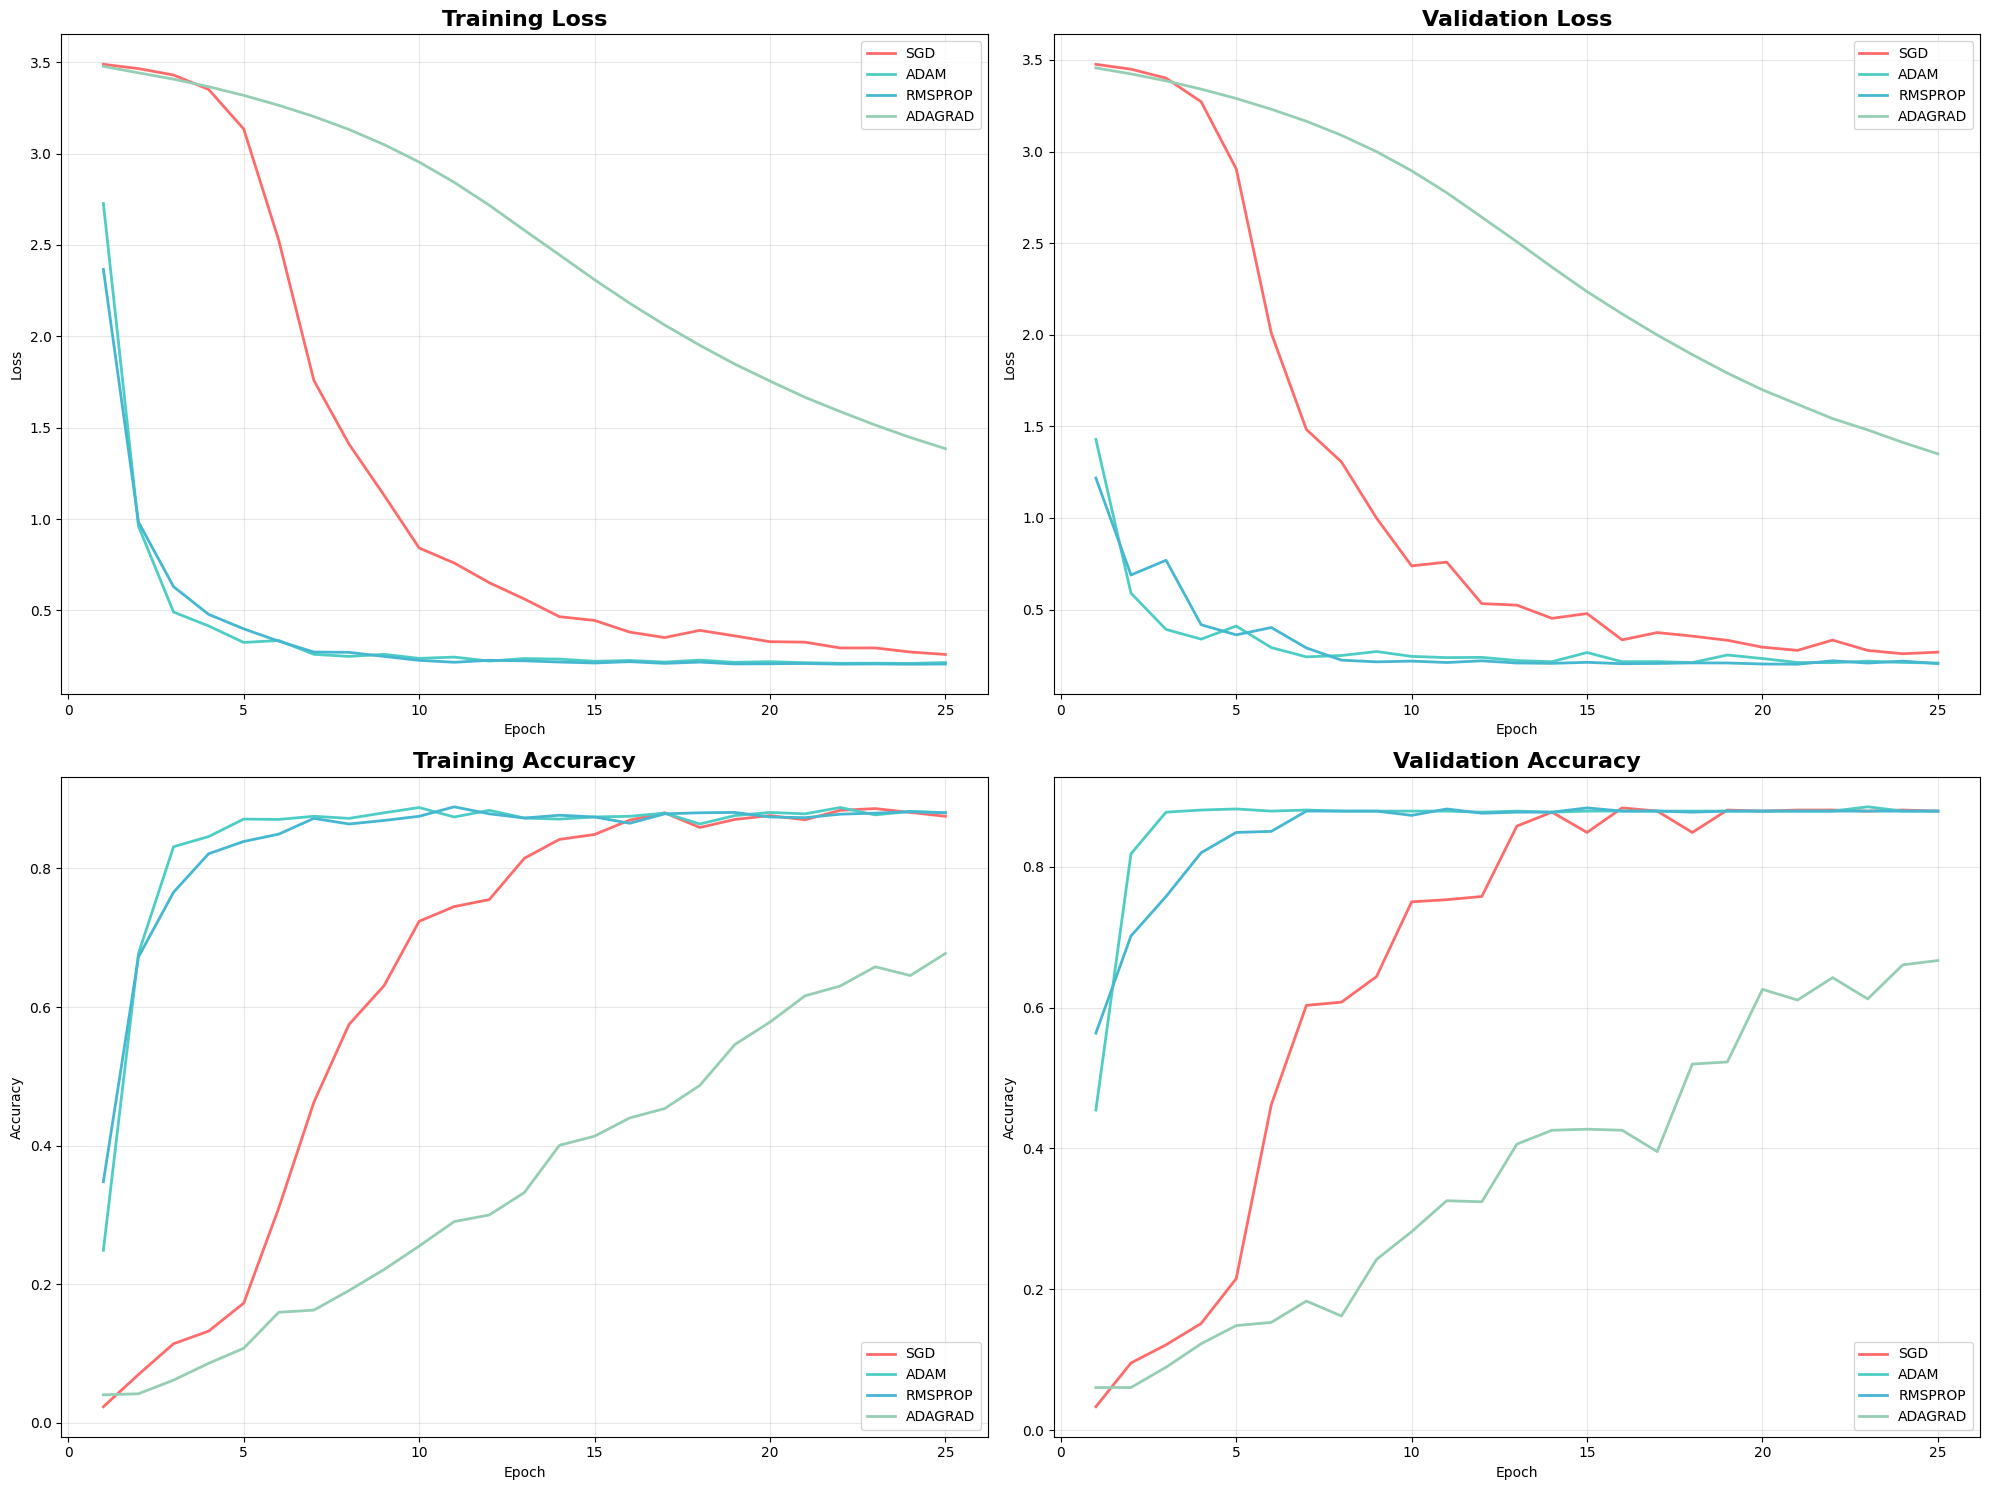

Performance graphs...


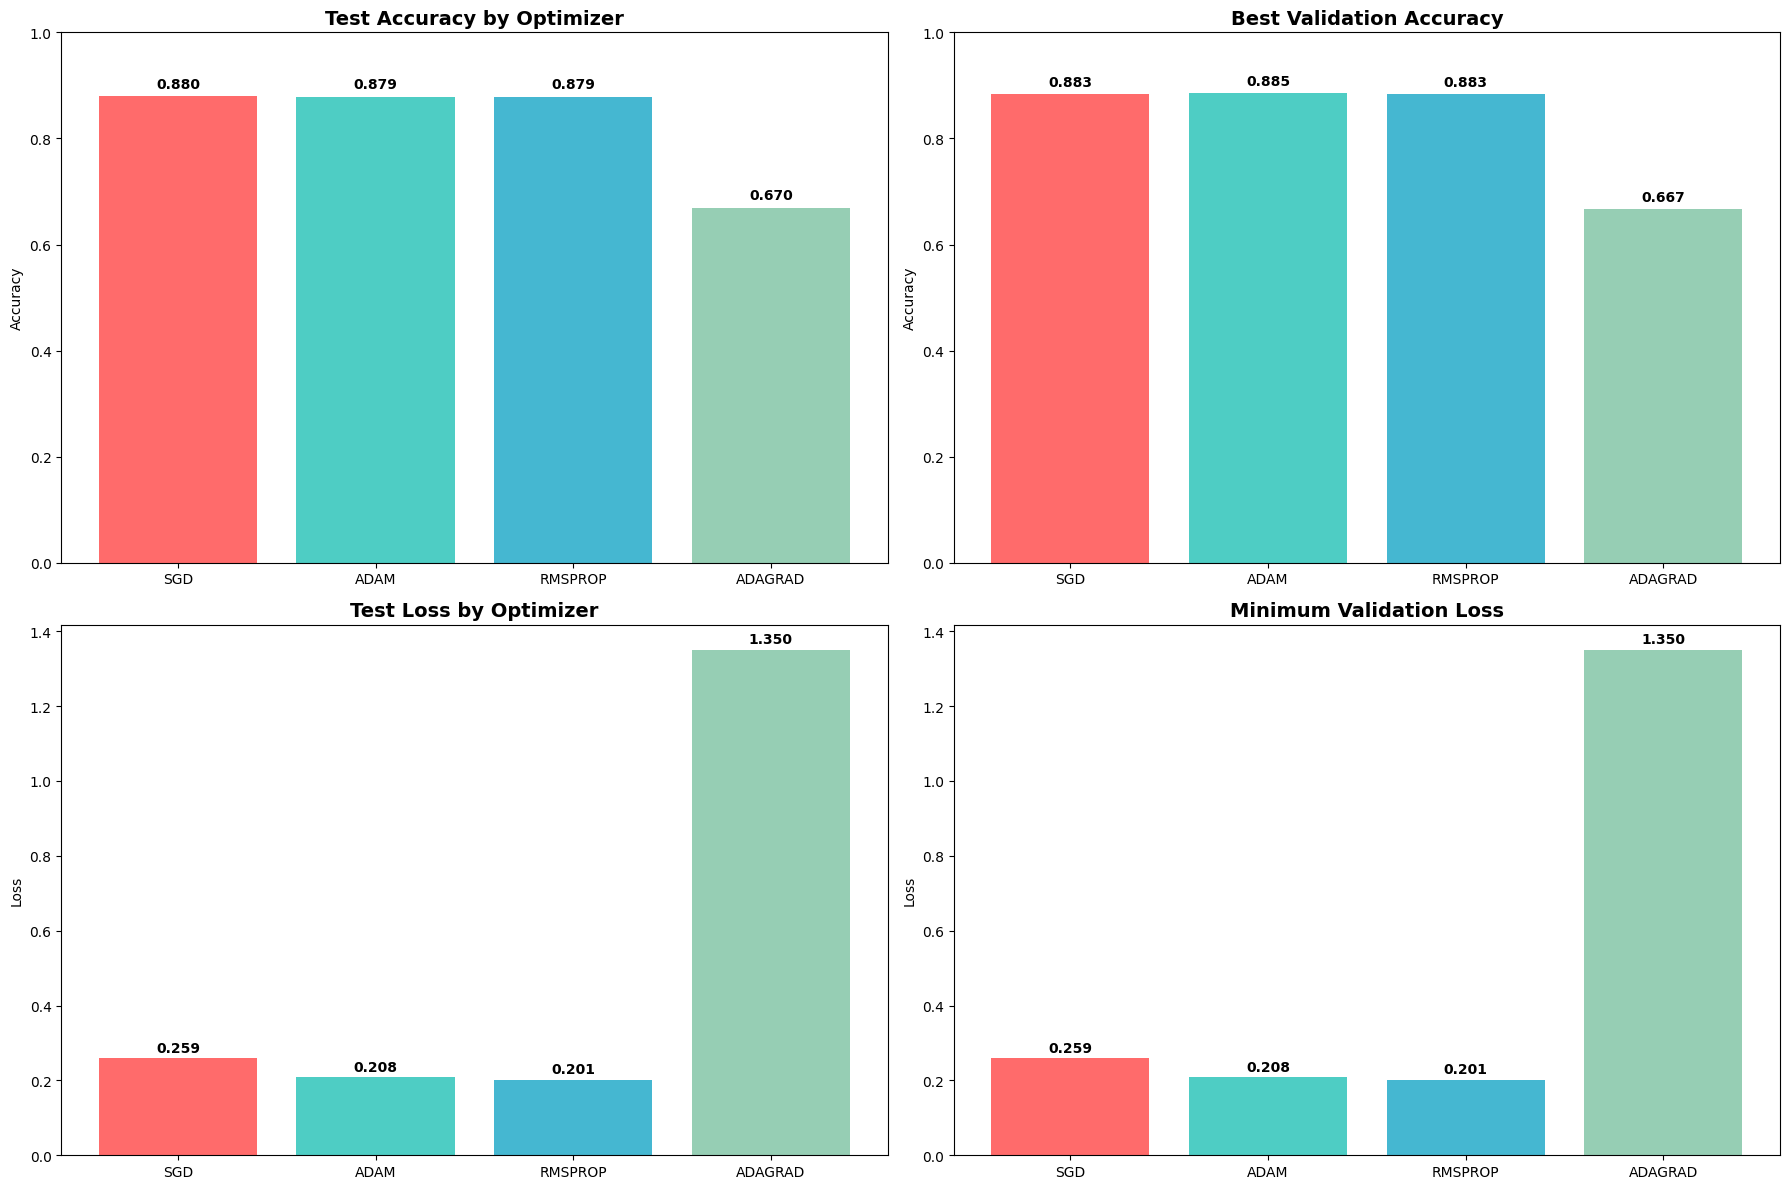

Convergence analysis...


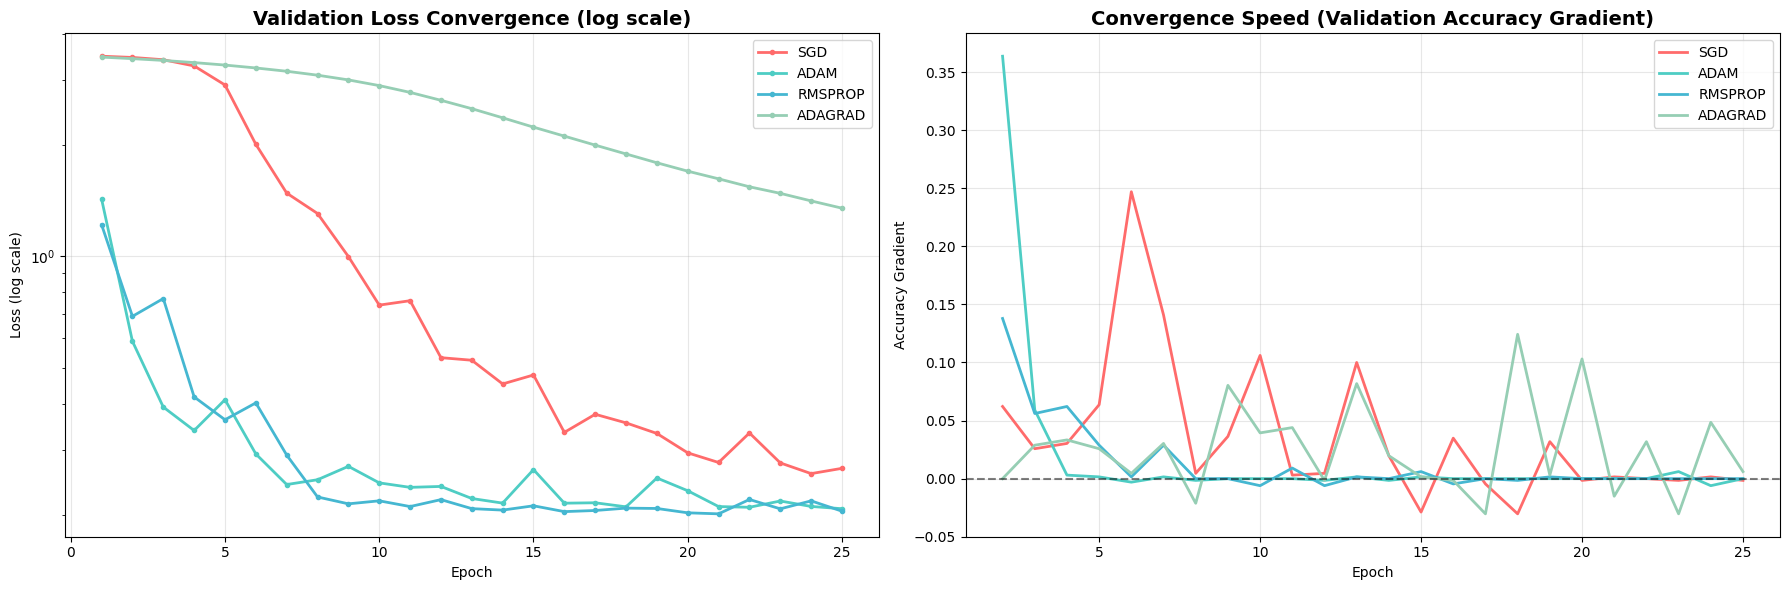

Generating summary report...
Summary Report - Optimizer Comparison
Optimizer Test Accuracy Test Loss Best Val Acc Val Loss Min  Epochs
      SGD        0.8803    0.2587       0.8833       0.2586      25
     ADAM        0.8788    0.2083       0.8848       0.2078      25
  RMSPROP        0.8788    0.2014       0.8833       0.2013      25
  ADAGRAD        0.6697    1.3497       0.6667       1.3497      25
Best Performance by Metric
Best Test Accuracy: SGD (0.8803)
Best Validation Accuracy: ADAM (0.8848)
Best Test Loss: RMSPROP (0.2014)
Best Validation Loss: RMSPROP (0.2013)
Recommendations
General Recommendation: RMSPROP
   Overall Score: 0.8649
   Justification: Best balance between performance and stability
Usage Tips:
   SGD: More stable but slow convergence, good for fine-tuning
   ADAM: Good default choice, fast convergence
   RMSPROP: Good for noisy data
   ADAGRAD: Adaptive but may stagnate in long sessions
Detailed analysis of best model...
Best optimizer: SGD
Test Accuracy: 0.88

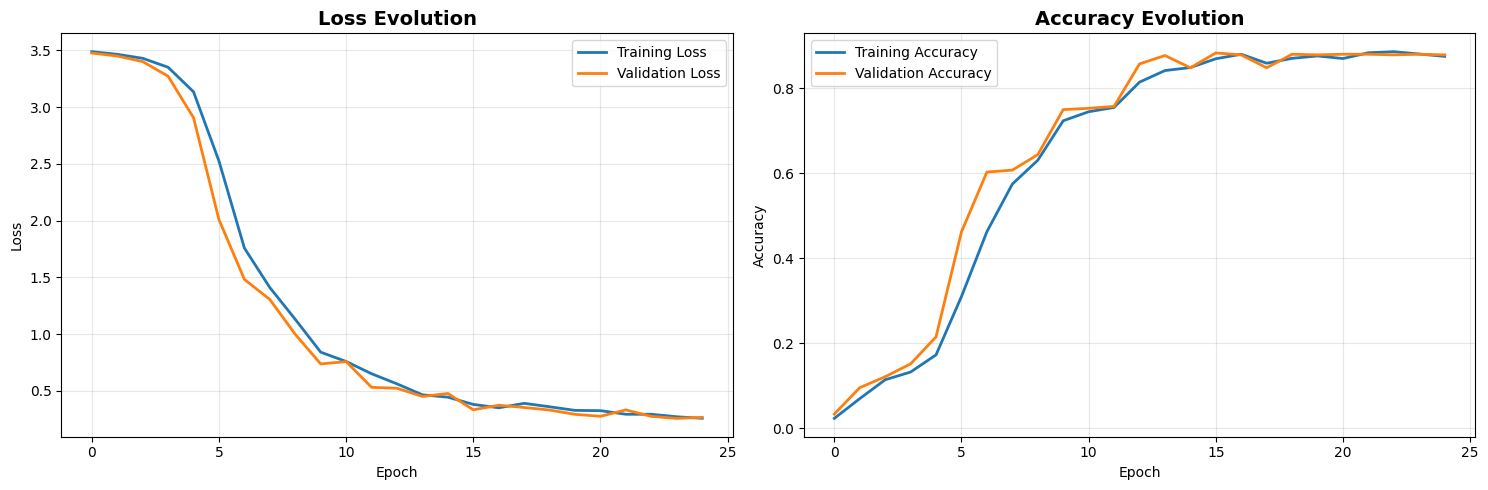

Confusion matrix for SGD:


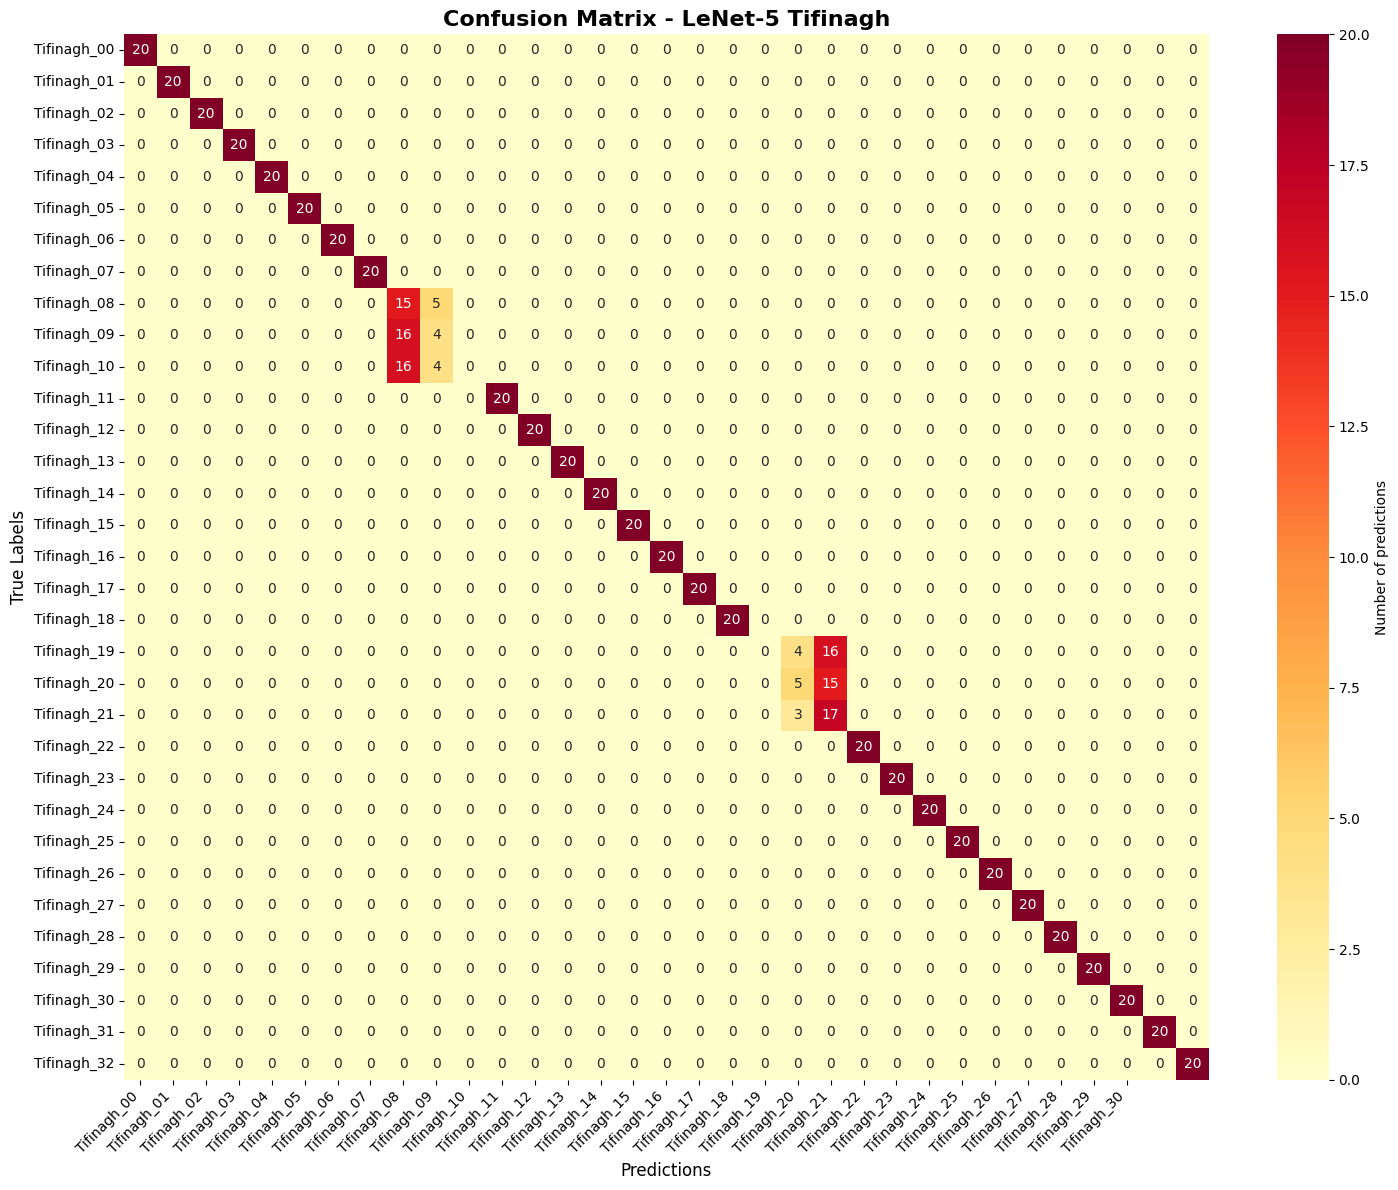

Final Recommendations

Comparison Results:
   4 optimizers tested
   1980 training samples
   660 test samples
   33 Tifinagh classes

Best Optimizer: SGD
   Test Accuracy: 0.8803
   Validation Accuracy: 0.8833
    
Complete analysis finished successfully!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd

class LeNet5:
    """
    Implementation of modified LeNet-5 for Tifinagh character classification
    Architecture: 32x32x1 -> C1 -> S2 -> C3 -> S4 -> C5 -> F6 -> Output(33)
    """

    def __init__(self, num_classes=33):
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        """
        Build LeNet-5 model with configurable layers
        """
        model = keras.Sequential([
            # Input layer
            layers.Input(shape=(32, 32, 1)),

            # C1: Convolution - 6 filters 5x5
            layers.Conv2D(filters=6, kernel_size=(5, 5),
                         activation='relu', padding='valid', name='C1'),

            # S2: Pooling - average 2x2, stride 2
            layers.AveragePooling2D(pool_size=(2, 2), strides=2, name='S2'),

            # C3: Convolution - 16 filters 5x5
            layers.Conv2D(filters=16, kernel_size=(5, 5),
                         activation='relu', padding='valid', name='C3'),

            # S4: Pooling - average 2x2, stride 2
            layers.AveragePooling2D(pool_size=(2, 2), strides=2, name='S4'),

            # Flatten for fully connected layers
            layers.Flatten(),

            # C5: Fully Connected - 120 neurons
            layers.Dense(120, activation='relu', name='C5'),

            # F6: Fully Connected - 84 neurons
            layers.Dense(84, activation='relu', name='F6'),

            # Output: 33 neurons for 33 classes
            layers.Dense(self.num_classes, activation='softmax', name='Output')
        ])

        self.model = model
        return model

    def compile_model(self, optimizer='adam', learning_rate=0.001):
        """
        Compile model with different optimizers
        """
        if optimizer.lower() == 'sgd':
            opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
        elif optimizer.lower() == 'adam':
            opt = optimizers.Adam(learning_rate=learning_rate)
        elif optimizer.lower() == 'rmsprop':
            opt = optimizers.RMSprop(learning_rate=learning_rate)
        elif optimizer.lower() == 'adagrad':
            opt = optimizers.Adagrad(learning_rate=learning_rate)
        else:
            opt = optimizer

        self.model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val,
              epochs=50, batch_size=32, verbose=1):
        """
        Train the model
        """
        # Convert labels to categorical format
        y_train_cat = to_categorical(y_train, self.num_classes)
        y_val_cat = to_categorical(y_val, self.num_classes)

        # Callbacks to improve training
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7
            )
        ]

        # Training
        self.history = self.model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """
        Evaluate model on test data
        """
        y_test_cat = to_categorical(y_test, self.num_classes)
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test_cat, verbose=0)

        # Predictions
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return test_loss, test_accuracy, y_pred_classes

    def plot_training_history(self):
        """
        Plot loss and accuracy curves
        """
        if self.history is None:
            print("No training history available")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss curve
        ax1.plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_title('Loss Evolution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy curve
        ax2.plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax2.plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax2.set_title('Accuracy Evolution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, class_names=None):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(15, 12))

        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                   xticklabels=class_names[:len(np.unique(y_pred))] if class_names else None,
                   yticklabels=class_names[:len(np.unique(y_true))] if class_names else None,
                   cbar_kws={'label': 'Number of predictions'})

        plt.title('Confusion Matrix - LeNet-5 Tifinagh', fontsize=16, fontweight='bold')
        plt.xlabel('Predictions', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def summary(self):
        """
        Display model summary
        """
        if self.model is not None:
            self.model.summary()
        else:
            print("Model not yet built")

class TifinaghDataLoader:
    """
    Class to load and preprocess Tifinagh data
    """

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.class_names = []

    def load_data(self, img_size=(32, 32)):
        """
        Load data from directory organized by classes
        """
        images = []
        labels = []

        # Get class names (folders)
        self.class_names = sorted([d for d in os.listdir(self.data_dir)
                                  if os.path.isdir(os.path.join(self.data_dir, d))])

        print(f"Classes found: {len(self.class_names)}")

        for class_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.data_dir, class_name)

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)

                    # Load and preprocess image
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img.astype(np.float32) / 255.0  # Normalization

                        images.append(img)
                        labels.append(class_idx)

        X = np.array(images)
        y = np.array(labels)

        # Add dimension for channel (grayscale)
        X = np.expand_dims(X, axis=-1)

        print(f"Data loaded: {X.shape[0]} images, {len(self.class_names)} classes")
        return X, y

    def create_synthetic_data(self, num_samples=3300):
        """
        Create realistic synthetic data for testing
        """
        print("Creating synthetic data for demonstration...")

        # Create more realistic data with distinct patterns for each class
        X = []
        y = []

        np.random.seed(42)  # For reproducibility

        for class_idx in range(33):
            samples_per_class = num_samples // 33

            for _ in range(samples_per_class):
                # Create image with class-specific pattern
                img = np.zeros((32, 32), dtype=np.float32)

                # Add simple geometric patterns based on class index
                if class_idx < 11:  # Horizontal lines
                    for i in range(class_idx + 1):
                        y_pos = 5 + i * 3
                        if y_pos < 30:
                            img[y_pos:y_pos+2, 5:27] = 1.0

                elif class_idx < 22:  # Vertical lines
                    lines = class_idx - 10
                    for i in range(lines):
                        x_pos = 5 + i * 3
                        if x_pos < 30:
                            img[5:27, x_pos:x_pos+2] = 1.0

                else:  # Geometric shapes
                    # Circles, squares, triangles
                    center_x, center_y = 16, 16
                    radius = (class_idx - 21) + 3

                    y_coords, x_coords = np.ogrid[:32, :32]
                    mask = (x_coords - center_x)**2 + (y_coords - center_y)**2 <= radius**2
                    img[mask] = 1.0

                # Add noise
                noise = np.random.normal(0, 0.1, (32, 32))
                img = np.clip(img + noise, 0, 1)

                # Add channel dimension
                img = np.expand_dims(img, axis=-1)

                X.append(img)
                y.append(class_idx)

        # Complete to have exactly num_samples
        while len(X) < num_samples:
            class_idx = np.random.randint(0, 33)
            # Copy and slightly modify an existing image
            base_img = X[class_idx * (num_samples // 33)]
            noise = np.random.normal(0, 0.05, base_img.shape)
            new_img = np.clip(base_img + noise, 0, 1)
            X.append(new_img)
            y.append(class_idx)

        X = np.array(X[:num_samples])
        y = np.array(y[:num_samples])

        # Create dummy class names
        self.class_names = [f"Tifinagh_{i:02d}" for i in range(33)]

        print(f"Synthetic data created: {X.shape}")
        return X, y

class OptimizerComparator:
    """
    Class to compare different optimizers
    """

    def __init__(self, num_classes=33):
        self.num_classes = num_classes
        self.results = {}
        self.optimizers = ['sgd', 'adam', 'rmsprop', 'adagrad']

    def compare_optimizers(self, X_train, y_train, X_val, y_val, X_test, y_test,
                          epochs=25, learning_rate=0.001):
        """
        Compare different optimizers with full training
        """
        print("Optimizer Comparison")

        for opt in self.optimizers:
            print(f"Training with {opt.upper()}")

            # Create new model for each optimizer
            lenet = LeNet5(num_classes=self.num_classes)
            lenet.build_model()
            lenet.compile_model(optimizer=opt, learning_rate=learning_rate)

            # Train model
            history = lenet.train(X_train, y_train, X_val, y_val,
                                epochs=epochs, verbose=1)

            # Evaluate on test data
            test_loss, test_accuracy, y_pred = lenet.evaluate(X_test, y_test)

            # Store results
            self.results[opt] = {
                'model': lenet,
                'history': history,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'y_pred': y_pred,
                'final_train_acc': history.history['accuracy'][-1],
                'final_val_acc': history.history['val_accuracy'][-1],
                'best_val_acc': max(history.history['val_accuracy']),
                'final_train_loss': history.history['loss'][-1],
                'final_val_loss': history.history['val_loss'][-1],
                'min_val_loss': min(history.history['val_loss'])
            }

            print(f"Results for {opt.upper()}:")
            print(f"  Training Accuracy: {self.results[opt]['final_train_acc']:.4f}")
            print(f"  Validation Accuracy: {self.results[opt]['final_val_acc']:.4f}")
            print(f"  Best Validation Accuracy: {self.results[opt]['best_val_acc']:.4f}")
            print(f"  Test Accuracy: {test_accuracy:.4f}")
            print(f"  Test Loss: {test_loss:.4f}")

        return self.results

    def plot_comparison_curves(self):
        """
        Plot training curves for all optimizers
        """
        if not self.results:
            print("No results to display. Run compare_optimizers() first")
            return

        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # Colors for each optimizer
        colors = {'sgd': '#FF6B6B', 'adam': '#4ECDC4', 'rmsprop': '#45B7D1', 'adagrad': '#96CEB4'}

        # 1. Training Loss
        ax1 = axes[0, 0]
        for opt, data in self.results.items():
            epochs = range(1, len(data['history'].history['loss']) + 1)
            ax1.plot(epochs, data['history'].history['loss'],
                    label=f'{opt.upper()}', color=colors[opt], linewidth=2)
        ax1.set_title('Training Loss', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Validation Loss
        ax2 = axes[0, 1]
        for opt, data in self.results.items():
            epochs = range(1, len(data['history'].history['val_loss']) + 1)
            ax2.plot(epochs, data['history'].history['val_loss'],
                    label=f'{opt.upper()}', color=colors[opt], linewidth=2)
        ax2.set_title('Validation Loss', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Training Accuracy
        ax3 = axes[1, 0]
        for opt, data in self.results.items():
            epochs = range(1, len(data['history'].history['accuracy']) + 1)
            ax3.plot(epochs, data['history'].history['accuracy'],
                    label=f'{opt.upper()}', color=colors[opt], linewidth=2)
        ax3.set_title('Training Accuracy', fontsize=16, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Validation Accuracy
        ax4 = axes[1, 1]
        for opt, data in self.results.items():
            epochs = range(1, len(data['history'].history['val_accuracy']) + 1)
            ax4.plot(epochs, data['history'].history['val_accuracy'],
                    label=f'{opt.upper()}', color=colors[opt], linewidth=2)
        ax4.set_title('Validation Accuracy', fontsize=16, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_performance_comparison(self):
        """
        Bar plots to compare final performance
        """
        if not self.results:
            print("No results to display. Run compare_optimizers() first")
            return

        # Prepare data
        optimizers = list(self.results.keys())
        test_accuracies = [self.results[opt]['test_accuracy'] for opt in optimizers]
        best_val_accuracies = [self.results[opt]['best_val_acc'] for opt in optimizers]
        test_losses = [self.results[opt]['test_loss'] for opt in optimizers]
        min_val_losses = [self.results[opt]['min_val_loss'] for opt in optimizers]

        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

        # 1. Test Accuracy
        ax1 = axes[0, 0]
        bars1 = ax1.bar([opt.upper() for opt in optimizers], test_accuracies, color=colors)
        ax1.set_title('Test Accuracy by Optimizer', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        for bar, acc in zip(bars1, test_accuracies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # 2. Best Validation Accuracy
        ax2 = axes[0, 1]
        bars2 = ax2.bar([opt.upper() for opt in optimizers], best_val_accuracies, color=colors)
        ax2.set_title('Best Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim(0, 1)
        for bar, acc in zip(bars2, best_val_accuracies):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. Test Loss
        ax3 = axes[1, 0]
        bars3 = ax3.bar([opt.upper() for opt in optimizers], test_losses, color=colors)
        ax3.set_title('Test Loss by Optimizer', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Loss')
        for bar, loss in zip(bars3, test_losses):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

        # 4. Minimum Validation Loss
        ax4 = axes[1, 1]
        bars4 = ax4.bar([opt.upper() for opt in optimizers], min_val_losses, color=colors)
        ax4.set_title('Minimum Validation Loss', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Loss')
        for bar, loss in zip(bars4, min_val_losses):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_convergence_analysis(self):
        """
        Analyze optimizer convergence
        """
        if not self.results:
            print("No results to display. Run compare_optimizers() first")
            return

        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        colors = {'sgd': '#FF6B6B', 'adam': '#4ECDC4', 'rmsprop': '#45B7D1', 'adagrad': '#96CEB4'}

        # 1. Validation Loss Convergence
        ax1 = axes[0]
        for opt, data in self.results.items():
            epochs = range(1, len(data['history'].history['val_loss']) + 1)
            val_loss = data['history'].history['val_loss']
            ax1.semilogy(epochs, val_loss, label=f'{opt.upper()}',
                        color=colors[opt], linewidth=2, marker='o', markersize=3)
        ax1.set_title('Validation Loss Convergence (log scale)',
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (log scale)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Convergence speed (accuracy gradient)
        ax2 = axes[1]
        for opt, data in self.results.items():
            val_acc = np.array(data['history'].history['val_accuracy'])
            gradient = np.diff(val_acc)
            epochs = range(2, len(val_acc) + 1)
            ax2.plot(epochs, gradient, label=f'{opt.upper()}',
                    color=colors[opt], linewidth=2)
        ax2.set_title('Convergence Speed (Validation Accuracy Gradient)',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy Gradient')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def generate_summary_report(self):
        """
        Generate summary report of results
        """
        if not self.results:
            print("No results to display. Run compare_optimizers() first")
            return

        print("Summary Report - Optimizer Comparison")

        # Create DataFrame for clear presentation
        data = []
        for opt, results in self.results.items():
            data.append({
                'Optimizer': opt.upper(),
                'Test Accuracy': f"{results['test_accuracy']:.4f}",
                'Test Loss': f"{results['test_loss']:.4f}",
                'Best Val Acc': f"{results['best_val_acc']:.4f}",
                'Val Loss Min': f"{results['min_val_loss']:.4f}",
                'Epochs': len(results['history'].history['loss'])
            })

        df = pd.DataFrame(data)
        print(df.to_string(index=False))

        # Find best optimizer for each metric
        best_test_acc = max(self.results.keys(), key=lambda x: self.results[x]['test_accuracy'])
        best_val_acc = max(self.results.keys(), key=lambda x: self.results[x]['best_val_acc'])
        best_test_loss = min(self.results.keys(), key=lambda x: self.results[x]['test_loss'])
        best_val_loss = min(self.results.keys(), key=lambda x: self.results[x]['min_val_loss'])

        print("Best Performance by Metric")
        print(f"Best Test Accuracy: {best_test_acc.upper()} ({self.results[best_test_acc]['test_accuracy']:.4f})")
        print(f"Best Validation Accuracy: {best_val_acc.upper()} ({self.results[best_val_acc]['best_val_acc']:.4f})")
        print(f"Best Test Loss: {best_test_loss.upper()} ({self.results[best_test_loss]['test_loss']:.4f})")
        print(f"Best Validation Loss: {best_val_loss.upper()} ({self.results[best_val_loss]['min_val_loss']:.4f})")

        # Recommendations
        print("Recommendations")

        # Calculate overall score (weighted average)
        scores = {}
        for opt in self.results.keys():
            stability_score = 1 / (1 + self.results[opt]['min_val_loss'])
            overall_score = 0.7 * self.results[opt]['test_accuracy'] + 0.3 * stability_score
            scores[opt] = overall_score

        best_overall = max(scores.keys(), key=lambda x: scores[x])

        print(f"General Recommendation: {best_overall.upper()}")
        print(f"   Overall Score: {scores[best_overall]:.4f}")
        print(f"   Justification: Best balance between performance and stability")

        # Specific advice
        print("Usage Tips:")
        for opt in self.optimizers:
            if opt == 'adam':
                print(f"   {opt.upper()}: Good default choice, fast convergence")
            elif opt == 'sgd':
                print(f"   {opt.upper()}: More stable but slow convergence, good for fine-tuning")
            elif opt == 'rmsprop':
                print(f"   {opt.upper()}: Good for noisy data")
            elif opt == 'adagrad':
                print(f"   {opt.upper()}: Adaptive but may stagnate in long sessions")

        return df

def main():
    """
    Main function to demonstrate LeNet-5 with optimizer comparison
    """
    print("LeNet-5 with Optimizer Comparison for Tifinagh")

    # 1. Load data
    print("Loading data...")
    data_loader = TifinaghDataLoader("/content/dataset/amhcd-data-64/tifinagh-images")

    # Use synthetic data for demonstration
    X, y = data_loader.create_synthetic_data(num_samples=3300)

    # 2. Split data
    print("Splitting data...")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    print(f"Training: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples")
    print(f"Test: {X_test.shape[0]} samples")

    # 3. Initialize optimizer comparator
    print("Initializing optimizer comparator...")
    comparator = OptimizerComparator(num_classes=33)

    # Run full comparison
    print("Comparing optimizers (this may take time)...")
    results = comparator.compare_optimizers(
        X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=25, learning_rate=0.001
    )

    # 5. Generate comparison visualizations
    print("Generating comparison visualizations...")

    # Training curves
    print("Training curves...")
    comparator.plot_comparison_curves()

    # Performance comparison
    print("Performance graphs...")
    comparator.plot_performance_comparison()

    # Convergence analysis
    print("Convergence analysis...")
    comparator.plot_convergence_analysis()

    # 6. Summary report
    print("Generating summary report...")
    summary_df = comparator.generate_summary_report()

    # 7. Detailed analysis of best model
    print("Detailed analysis of best model...")

    # Find best optimizer based on test accuracy
    best_optimizer = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    best_model = results[best_optimizer]['model']
    best_predictions = results[best_optimizer]['y_pred']

    print(f"Best optimizer: {best_optimizer.upper()}")
    print(f"Test Accuracy: {results[best_optimizer]['test_accuracy']:.4f}")

    # Display training curves for best model
    print(f"Training curves for {best_optimizer.upper()}:")
    best_model.plot_training_history()

    # Confusion matrix for best model
    if results[best_optimizer]['test_accuracy'] > 0.1:
        print(f"Confusion matrix for {best_optimizer.upper()}:")
        best_model.plot_confusion_matrix(y_test, best_predictions, data_loader.class_names)

    # 8. Final recommendations
    print("Final Recommendations")

    print(f"""
Comparison Results:
   {len(results)} optimizers tested
   {len(X_train)} training samples
   {len(X_test)} test samples
   33 Tifinagh classes

Best Optimizer: {best_optimizer.upper()}
   Test Accuracy: {results[best_optimizer]['test_accuracy']:.4f}
   Validation Accuracy: {results[best_optimizer]['best_val_acc']:.4f}
    """)

    return comparator, results

def analyze_optimizer_behavior(comparator, optimizer_name):
    """
    Detailed analysis of specific optimizer behavior
    """
    if optimizer_name not in comparator.results:
        print(f"Optimizer {optimizer_name} not found in results")
        return

    result = comparator.results[optimizer_name]
    history = result['history'].history

    print(f"Detailed Analysis - {optimizer_name.upper()}")

    # Convergence statistics
    train_acc = np.array(history['accuracy'])
    val_acc = np.array(history['val_accuracy'])
    train_loss = np.array(history['loss'])
    val_loss = np.array(history['val_loss'])

    # Find best validation epoch
    best_epoch = np.argmax(val_acc) + 1

    print(f"Convergence:")
    print(f"   Best epoch: {best_epoch}")
    print(f"   Accuracy at best epoch: {val_acc[best_epoch-1]:.4f}")
    print(f"   Overfitting (train-val gap): {train_acc[-1] - val_acc[-1]:.4f}")

    # Stability
    val_acc_std = np.std(val_acc[-10:])
    print(f"   Stability (std of last 10 epochs): {val_acc_std:.4f}")

    # Trends
    early_acc = np.mean(val_acc[:5])
    late_acc = np.mean(val_acc[-5:])
    print(f"   Overall improvement: {late_acc - early_acc:.4f}")

def compare_learning_rates(X_train, y_train, X_val, y_val, optimizer='adam'):
    """
    Compare different learning rates for a given optimizer
    """
    learning_rates = [0.1, 0.01, 0.001, 0.0001]
    results = {}

    print(f"Learning Rate Comparison - {optimizer.upper()}")

    for lr in learning_rates:
        print(f"Testing with learning rate: {lr}")

        lenet = LeNet5(num_classes=33)
        lenet.build_model()
        lenet.compile_model(optimizer=optimizer, learning_rate=lr)

        history = lenet.train(X_train, y_train, X_val, y_val,
                            epochs=15, verbose=0)

        best_val_acc = max(history.history['val_accuracy'])
        results[lr] = {
            'best_val_acc': best_val_acc,
            'history': history
        }

        print(f"   Best validation accuracy: {best_val_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 8))

    for lr, data in results.items():
        epochs = range(1, len(data['history'].history['val_accuracy']) + 1)
        plt.plot(epochs, data['history'].history['val_accuracy'],
                label=f'LR = {lr}', linewidth=2, marker='o', markersize=4)

    plt.title(f'Learning Rate Comparison - {optimizer.upper()}',
              fontsize=16, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Best learning rate
    best_lr = max(results.keys(), key=lambda x: results[x]['best_val_acc'])
    print(f"Best learning rate: {best_lr}")
    print(f"   Accuracy: {results[best_lr]['best_val_acc']:.4f}")

    return results

def data_augmentation_demo(X_train, y_train):
    """
    Demonstrate data augmentation
    """
    print("Data Augmentation Demonstration")

    # Create augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

    # Visualize augmentation examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Take sample image
    sample_image = X_train[0:1]  # Shape: (1, 32, 32, 1)

    # Generate augmented versions
    datagen.fit(sample_image)
    augmented_images = []

    for batch in datagen.flow(sample_image, batch_size=1):
        augmented_images.append(batch[0])
        if len(augmented_images) >= 9:
            break

    # Display original image
    axes[0, 0].imshow(sample_image[0, :, :, 0], cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    # Display augmented images
    for i, aug_img in enumerate(augmented_images[:9]):
        row = (i + 1) // 5
        col = (i + 1) % 5
        axes[row, col].imshow(aug_img[:, :, 0], cmap='gray')
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')

    plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return datagen

if __name__ == "__main__":
    # Run main analysis
    comparator, results = main()

    print("Complete analysis finished successfully!")